<a href="https://colab.research.google.com/github/tsancode/Population5/blob/miftarj-model/Population5%20Update%20Preliminary_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import package yg diperlukan

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import requests
from io import StringIO

from tensorflow import keras
from tensorflow import nn

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


Import data

In [ ]:
orig_url2='https://drive.google.com/file/d/1BBmMNqARjiuM71WtrldCJ8WZesmfs14v/view?usp=sharing'

file_id2 = orig_url2.split('/')[-2]
dwn_url2='https://drive.google.com/uc?export=download&id=' + file_id2
url2 = requests.get(dwn_url2).text
csv_raw2 = StringIO(url2)
df2 = pd.read_csv(csv_raw2)

Exploratory

In [ ]:
df2.head()

,tahun,wil_id,wilayah,usia_prod
0,2013,1,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,1846
1,2013,2,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,1520
2,2013,3,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU SELATANP...,3336
3,2013,4,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU UTARAPUL...,4396
4,2013,5,ADM. KEPULAUAN SERIBUKEPULAUAN SERIBU UTARAPUL...,1446


In [ ]:
df2.shape

(2403, 4)

In [ ]:
df2['tahun'] = pd.to_datetime(df2['tahun'], format='%Y') 

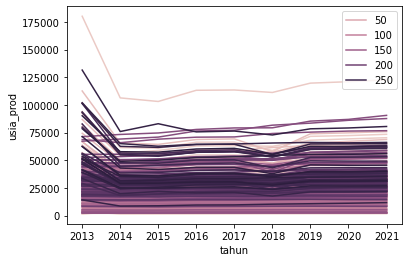

In [ ]:

sns.lineplot(data = df2, x = 'tahun', y = 'usia_prod', hue = 'wil_id')
plt.legend(loc='upper right')
plt.show()


Model

In [ ]:
window = 267

In [ ]:
# This value is the window size we are using
index = window

feature, target = [], []

while(index < df2.shape[0]):
    feature.append(df2.iloc[index - window: index]['usia_prod'].to_numpy())
    target.append(df2.iloc[index][['usia_prod', 'tahun']].to_numpy())
    index = index + 1
feature = np.array(feature)
target = np.array(target)   

In [ ]:
size_test = int(df2['tahun'].value_counts().index.shape[0] * 0.8)
separation_date = df2['tahun'].value_counts().index.sort_values()[size_test]

In [ ]:
x_train0, y_train0, x_test0, y_test0 = [], [], [], []
for i,t in enumerate(target):
    if t[1] < separation_date:
        x_train0.append(feature[i])
        y_train0.append(target[i][0])
    else:
        x_test0.append(feature[i])
        y_test0.append(target[i][0])

In [ ]:
x_train0, x_test0 = np.array(x_train0), np.array(x_test0)
y_train0, y_test0 = np.array(y_train0).reshape(-1, 1), np.array(y_test0).reshape(-1, 1)

In [ ]:
scaler_feature = StandardScaler()
scaler_feature.fit(x_train0)
x_train = scaler_feature.transform(x_train0)
x_test = scaler_feature.transform(x_test0)

# Reshaping features for the LSTM
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

scaler_target = StandardScaler()
scaler_target.fit(y_train0)
y_train = scaler_target.transform(y_train0)
y_test = scaler_target.transform(y_test0)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(units = 128))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 267, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 267, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
51/51 [==============================] - 47s 842ms/step - loss: 0.8803 - val_loss: 0.9338
Epoch 2/10
51/51 [==============================] - 36s 693ms/step - loss: 0.7438 - val_loss: 0.8267
Epoch 3/10
51/51 [==============================] - 31s 604ms/step - loss: 0.7094 - val_loss: 0.8047
Epoch 4/10
51/51 [==============================] - 28s 544ms/step - loss: 0.7001 - val_loss: 0.7694
Epoch 5/10
51/51 [==============================] - 29s 567ms/step - loss: 0.6774 - val_loss: 0.7878
Epoch 6/10
51/51 [==============================] - 27s 536ms/step - loss: 0.7545 - val_loss: 0.7459
Epoch 7/10
51/51 [==============================] - 28s 549ms/step - loss: 0.6491 - val_loss: 0.7387
Epoch 8/10
51/51 [==============================] - 28s 557ms/step - loss: 0.6419 - val_loss: 0.7302
Epoch 9/10
51/51 [==============================] - 27s 539ms/step - loss: 0.6364 - val_loss: 0.7523
Epoch 10/10
51/51 [==============================] - 28s 547ms/step - loss: 0.6267 - val_lo

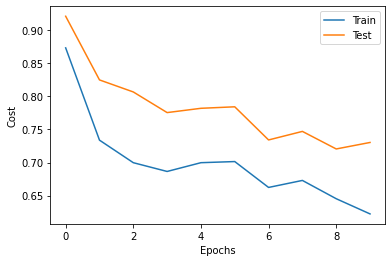

In [ ]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

print_loss(result)

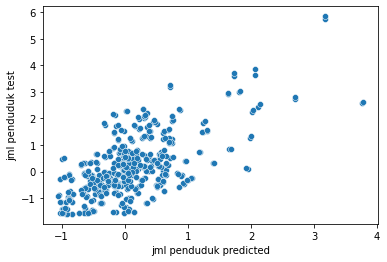

In [ ]:
y_predict = model.predict(x_test)

ax = sns.scatterplot(x=y_predict[:,0], y=y_test[:,0])
ax.set_ylabel('jml penduduk test')
ax.set_xlabel('jml penduduk predicted')
plt.show()

In [ ]:
y_predicted = scaler_target.inverse_transform(y_predict)

In [ ]:
diff = y_predicted - y_test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 959558030.1098733
MAE: 28864.529018805497
RMSE: 30976.733690140303


In [ ]:
len(y_predicted)

534

Prediction 2022

In [ ]:
x_test_ = x_test0.copy()
y_predicted=np.array(y_predicted)
y_predicted_=np.reshape(y_predicted[267:,0], (1,window))


In [ ]:
x_test_= np.vstack((x_test_,y_predicted_))

In [ ]:
scaler_feature.fit(x_test_)
x_test_ = scaler_feature.transform(x_test_)

# Reshaping features for the LSTM
x_test_ = x_test_.reshape(-1,window,1)

In [ ]:
predict_ = model.predict(x_test_)



In [ ]:
y_predicted_ = scaler_target.inverse_transform(predict_)

In [ ]:

print("Prediksi th 2022:", y_predicted_[267:])

Prediksi th 2022: [[29569.504]
 [21328.688]
 [16275.82 ]
 [14767.17 ]
 [18957.65 ]
 [29070.113]
 [39462.383]
 [68944.66 ]
 [86314.73 ]
 [79162.664]
 [61416.566]
 [37736.82 ]
 [27185.127]
 [20404.848]
 [18531.824]
 [20671.191]
 [22087.475]
 [23273.102]
 [31168.594]
 [42382.523]
 [59396.59 ]
 [61619.207]
 [60393.754]
 [54835.594]
 [49032.312]
 [41240.027]
 [35424.215]
 [30506.322]
 [29350.25 ]
 [26911.613]
 [27952.479]
 [29861.3  ]
 [32123.17 ]
 [31088.42 ]
 [35650.59 ]
 [34485.31 ]
 [34688.8  ]
 [34886.836]
 [31537.758]
 [29080.193]
 [25617.16 ]
 [23475.37 ]
 [28612.703]
 [25241.955]
 [19425.777]
 [16840.178]
 [16027.964]
 [13423.289]
 [13248.219]
 [12462.836]
 [12732.073]
 [12978.383]
 [17190.773]
 [16419.564]
 [16598.088]
 [19574.582]
 [19028.807]
 [19112.541]
 [18030.406]
 [18171.234]
 [12354.02 ]
 [10969.875]
 [16298.388]
 [23421.93 ]
 [22796.16 ]
 [20790.521]
 [17070.121]
 [16789.225]
 [10958.08 ]
 [10717.66 ]
 [13326.025]
 [16386.176]
 [18610.62 ]
 [27143.062]
 [25052.25 ]
 [28930